In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Interpolations
using DSP
using FFTW
using NCDatasets
using JLD2

include("./read_lidar.jl")
using .read_lidar
# using MAT

using PyPlot

  Activating project at `~/Projects/ASTRAL/lidar`


In [2]:
# utility functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

"bin average y in bins b of coordinate x"
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end

# functions for masking and averaging data

"NaN -> missing"
n2m(x) = isfinite.(x) ? x : missing

"result is x; set to missing iff i<thr"
masklowi(x, i, thr=1.03) = i<thr ? missing : x

"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

"anomaly"
anom(x; dims=1) = x.-mean(x; dims=dims)

# make simple linear temporal interpolation
# maybe fast
# most time is spent searching for indices
# indices are monotonic

"find indices i such that each xl[i] is the first >= xs."
function findindices(xs, xl)
    # xs needles define quarries in haystack xl
    xs = filter(x -> x<=last(xl), xs) # prefilter to avoid running off the end of xl
    ind = zeros(Int64, size(xs))
    i = 1
    for (j,x) in enumerate(xs)
        while xl[i] < x
            i += 1
        end
        ind[j] = i
    end
    return ind
end

"average within +-half points of the index of xl"
function indavg(xl, ind; half=5)
    xm = zeros(Float64, size(ind))
    for (i,idx) in enumerate(ind)
        ii = max(1,idx-half) : min(length(xl),idx+half)
        xm[i] = sum(Float64.(xl[ii])) / (2*half+1)
    end
    return xm
end

# test data
xl = 1:60_000_000
xs = 20:20:60_000_000

ind = findindices(xs, xl)
indavg(xl, ind)

"return the coherent component of signal1 and signal2"
function coherent_component(signal1::Vector{Float64}, signal2::Vector{Float64})
    # Fourier Transform of the signals
    S1 = fft(signal1)
    S2 = fft(signal2)
    
    # Compute cross-spectral density
    P12 = S1 .* conj(S2)
    # P21 = conj(P12)
    
    # Compute auto-spectral density
    P11 = S1 .* conj(S1)
    P22 = S2 .* conj(S2)
    
    # Compute coherence
    coherence = abs.(P12).^2 ./ (P11 .* P22)
    
    # Compute the coherent part
    coherent_part_S1 = coherence .* S2
    coherent_part_S2 = coherence .* S1
    
    # Inverse Fourier Transform to get the time-domain signals
    coherent_signal1 = real(ifft(coherent_part_S1))
    coherent_signal2 = real(ifft(coherent_part_S2))
    
    return coherent_signal1, coherent_signal2
end

"remove the coherent component of signal1 and signal2"
function remove_coherent_component(signal1::Vector{Float64}, signal2::Vector{Float64})
    # Fourier Transform of the signals
    S1 = fft(signal1)
    S2 = fft(signal2)
    
    # Compute cross-spectral density
    P12 = S1 .* conj(S2)
    # P21 = conj(P12)
    
    # Compute auto-spectral density
    P11 = S1 .* conj(S1)
    P22 = S2 .* conj(S2)
    
    # Compute coherence
    coherence = abs.(P12).^2 ./ (P11 .* P22)
    
    # Compute the coherent part
    coherent_part_S1 = coherence .* S2
    coherent_part_S2 = coherence .* S1
    
    # Remove the coherent part
    clean_S1 = S1 .- coherent_part_S1
    clean_S2 = S2 .- coherent_part_S2
    
    # Inverse Fourier Transform to get the time-domain signals
    clean_signal1 = real(ifft(clean_S1))
    clean_signal2 = real(ifft(clean_S2))
    
    return clean_signal1, clean_signal2
end

remove_coherent_component

In [3]:
#= test stuff out
nt = 1000
nc = 3

# construct the indices of the combination sets
ci = CartesianIndices((nt,nc))
li = LinearIndices(ci)

# Generate the set of unique pairs of indices (l1,l2)
# where l1 < l2.
# Set() makes unique but it's slow and the result of the comprehension is already unique. 
lpairs = [ (l1, l2) for l1 in li[:] for l2 in (l1+1):last(li) ]
l1 = first.(lpairs) # vector of linear indices to points 1 of pairs
l2 =  last.(lpairs) #                             points 2
# str_fcn = w[ci[l1]] - w[ci[l2]])

# w can be indexed directly with ci[first.(lpairs])
# unpack the CartesianIndex to subscript the time[it], range[iz]
# idx[1] works but first(idx) tries to iterate which is unsupported
it1 = map(idx->idx[1], ci[l1]) #  t index of first point(s)
iz1 = map(idx->idx[2], ci[l1]) #  z index of first
it2 = map(idx->idx[1], ci[l2]) #  t       of second points(s)
iz2 = map(idx->idx[2], ci[l2]) #  z          second
#     first.(Tuple.(ci[l1])) # this also works

=#

In [4]:
# functions for structure functions

# generate unique pairs of indices
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# beam geometry
"lidar beam range"
rng(iz, rangegate=24.0) = rangegate * (iz-1 + 0.5)

"""
compile indices of lidar volumes to be compared with
structure functions
"""
function lidarindices(nt, nz, z1=1; nlevelstats=1)
    if nlevelstats == 3
        # The complete set that doesn't repeat pairs is 
        # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
        # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
        # Iteratively slide this box upward by 1 level for each level.
    
        # index pairs in middle level 2-2
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r22 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r22 = CartesianIndex.(tuple.(it2,z1)) # 2nd 
    
        # index pairs of points from level 2-1, and 2-3
        ac = allcross(nt)
        it1 = map(i->i[1], ac)
        it2 = map(i->i[2], ac)
        ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
        ci2_r21 = CartesianIndex.(tuple.(it2,z1-1))
        ci2_r23 = CartesianIndex.(tuple.(it2,z1+1))
    
        # omnibus set of cartesian index pairs for a level, including points in lev above and below
        ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
        ci2 = [ci2_r23; ci2_r22; ci2_r21]
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
        
    elseif nlevelstats == 1
        # just use structure function velocity pairs from one level of lidar range
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r11 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r11 = CartesianIndex.(tuple.(it2,z1)) # 2nd point in same lev
    
        # set of cartesian index pairs for a level, including points in lev above and below
        ci1 = ci1_r11 # first of pairs
        ci2 = ci2_r11
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
    end
    
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second
    
    return ci1,ci2, li1,li2, it1,iz1,it2,iz2
end

# try example
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(1000, 80)

#= moved to function
nlevelstats = 1

if nlevelstats == 3
    # The complete set that doesn't repeat pairs is 
    # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
    # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
    # Iteratively slide this box upward by 1 level for each level.

    # index pairs in middle level 2-2
    up = uniquepairs(nt)
    it1 = map(i->i[1], up) # time indices for pairs of point1, point2
    it2 = map(i->i[2], up)
    ci1_r22 = CartesianIndex.(tuple.(it1,2)) # 1st point in pair lev
    ci2_r22 = CartesianIndex.(tuple.(it2,2)) # 2nd 

    # index pairs of points from level 2-1, and 2-3
    ac = allcross(nt)
    it1 = map(i->i[1], ac)
    it2 = map(i->i[2], ac)
    ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
    ci2_r21 = CartesianIndex.(tuple.(it2,1))
    ci2_r23 = CartesianIndex.(tuple.(it2,3))

    # omnibus set of cartesian index pairs for a level, including points in lev above and below
    ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
    ci2 = [ci2_r23; ci2_r22; ci2_r21]
    li1 = LinearIndices(ci1)
    li2 = LinearIndices(ci2)
    
elseif nlevelstats == 1
    # just use structure function velocity pairs from one level of lidar range
    up = uniquepairs(nt)
    it1 = map(i->i[1], up) # time indices for pairs of point1, point2
    it2 = map(i->i[2], up)
    ci1_r11 = CartesianIndex.(tuple.(it1,1)) # 1st point in pair lev
    ci2_r11 = CartesianIndex.(tuple.(it2,1)) # 2nd 

    # set of cartesian index pairs for a level, including points in lev above and below
    ci1 = ci1_r11 # first of pairs
    ci2 = ci2_r11
    li1 = LinearIndices(ci1)
    li2 = LinearIndices(ci2)
end

it1 = map(idx->idx[1], ci1) #  t index of first point(s)
iz1 = map(idx->idx[2], ci1) #  z index of first
it2 = map(idx->idx[1], ci2) #  t       of second points(s)
iz2 = map(idx->idx[2], ci2) #  z          second
=#

(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1)  …  CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(998, 1), CartesianIndex(999, 1)], CartesianIndex{2}[CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1), CartesianIndex(11, 1)  …  CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(1000, 1)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 1

In [5]:
# Adjust true vertical velocity for relative wind * sin(tilt)
# and the platform velocity
trigs(pitch, roll) = ( cos(pitch), sin(pitch), cos(roll), sin(roll) )
# cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)

function wtrue(w, Ur, Vr, pitch, roll)
    cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)
    wtrue = ( w + Ur*sinpitch - Vr*cospitch*sinroll ) / (cospitch*cosroll)
end

# displacements with no adjustment for tilting into the horizontal wind 
# U, V vary slowly; pitch,roll,w vary fast
# there are nt*(nt-1)/2 ~ O(nt^2) outputs, so correct stuff first

rangegate = 24.0
"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate , timestep=timestep)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # CORRECT W for HEAVE and for TILTING into the horizontal wind
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

## example load data sets

In [6]:
# functions to resynchronize the lidar clock

# make filter
responsetype = Highpass(1/80; fs=1)
designmethod = Butterworth(4)
"highpass filter"
hp(x) = filtfilt(digitalfilter(responsetype, designmethod), x)

"""
get_time_shift(mdv, heave) positive result means mdv clock is fast.
sync by subtracting this lag (index) from stare_dt.
"""
function get_time_shift(mdv, heave)
    # filter to make xcorr work better
    xc = xcorr(hp(mdv[:]), hp(heave[:]))
    # plot(-(length(mdv)-1):length(mdv)-1, xc )
    return argmax(xc) - length(mdv)
end

# broken:
# """
# Returns the decremented stare_dt by time offset subtracted from the lidar clock.
# """
# function sync_lidar_clock(stare_dt, mdv, heave)
#     lidar_clock_fast_by = Millisecond( 1020*get_time_shift(mdv[:],heave[:]) ) # first adjustment
#     # return decremented clock
#     return stare_dt.+lidar_clock_fast_by, lidar_clock_fast_by
# end

get_time_shift

In [7]:
#example time
dt = DateTime(2024,5,8,6,0,0)
# heave channel constant on 2024-5-12
# no mean wind on 2024-05-12

# load vectornav
Vn = read_daily_Vn( dt )            # Dict

# load mean relative horizontal winds
UV = get_daily_meanuv( dt )         # NCDataset
# relative wind computed by Jayesh Phadtare

# load hourly lidar w stares
ntop = 80       # subset
timestep = 1.02 # s
# TO DO: read the next hour to get continuous chunk at end ...
St, _ = read_streamlinexr_stare( dt )
height = St[:height][1:ntop]

# time subsets
stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(Int64( St[:time] * 3_600_000 )) # 3202
# Lidar clock is fast (ahead) by 126832 milliseconds compared to the GPS.
# Moving the timeseries backward (lagging the lidar) compensates its clock error.
# adjust the lidar clock backward to agee with the GPS clock.
lidar_clock_fast_by = Millisecond( 126832 ) # first adjustment
stare_dt = stare_dt_raw .- lidar_clock_fast_by

3202-element Vector{DateTime}:
 2024-05-08T05:58:12.168
 2024-05-08T05:58:13.198
 2024-05-08T05:58:14.218
 2024-05-08T05:58:15.238
 2024-05-08T05:58:16.258
 2024-05-08T05:58:17.278
 2024-05-08T05:58:18.308
 2024-05-08T05:58:19.328
 2024-05-08T05:58:20.348
 2024-05-08T05:58:21.368
 ⋮
 2024-05-08T06:57:44.968
 2024-05-08T06:57:45.988
 2024-05-08T06:57:47.008
 2024-05-08T06:57:48.028
 2024-05-08T06:57:49.048
 2024-05-08T06:57:50.078
 2024-05-08T06:57:51.098
 2024-05-08T06:57:52.118
 2024-05-08T06:57:53.138

In [8]:
function sync_lidar2heave( stare1dt, mdv, Vn )
    ind = findindices( stare1dt, Vn["time"] )
    # heave = Vn["heave"][ind]
    heave = indavg( Vn["heave"], ind )
    shift = get_time_shift(mdv[:],heave[:]) # index of time shift
    # refine the lidar time
    shiftt = stare1dt[shift+1] - stare1dt[1]
    stare1dt .- shiftt # Millisecond((1020)*shift)
end

sync_lidar2heave (generic function with 1 method)

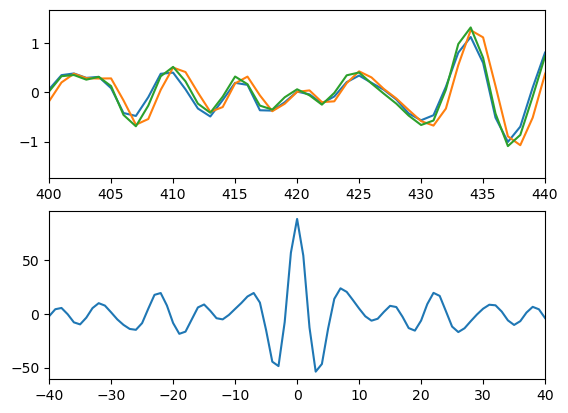

In [19]:
# split into individual stare chunks

# A stare time interval goes from 5:15 to 14:22 (367 s), 53 seconds mean wind scan, then 15:15-24:22, etc.
# The first and last chunks are partial, split between earlier and later hourly data files.
# First cut, ignore the partial chunks.
pickets = findall( t -> t>Second(30), diff(stare_dt) )
# st = [1; pickets.+1] # ignore start and end of file with a split chunk
# en = [pickets; length(stare_dt)]
st_chunk = pickets[1:end-1] .+ 1
en_chunk = pickets[2:end]

# loop over continuous chunks
  # for (ich, st) in enumerate(st_chunk) ...
# test one chunk
st = st_chunk[5]
en = en_chunk[5]

# dopplervel (time, z) masked by intensity
# intensity = St[:intensity]
dopplervel = masklowi.(St[:dopplervel][st:en,1:ntop], St[:intensity][st:en,1:ntop])
mdv = missmean(dopplervel, dims=2)[:]
# do not use pitch and roll from the lidar, they're bad
# pitch = St[:pitch][st:en] # from lidar
# roll =  St[:roll ][st:en]

# interpolate Ur,Vr, heave to the lidar stare grid
# My simple 1D interpolation is way faster than Interpolations.interpolate.
ind = findindices( stare_dt[st:en], Vn["time"] )
# vntime = indavg( Vn["time"], ind)
pitch = indavg( Vn["pitch"], ind) # 11-point mean
roll  = indavg( Vn["roll" ], ind)
heave = indavg( Vn["heave"], ind)

# resync the clock to the VectorNav heave
stare1dt = stare_dt[st:en] # subset
stare2dt = sync_lidar2heave( stare1dt, mdv, Vn )
# reinterpolate heave
ind = findindices( stare2dt, Vn["time"] ) # this works
# ind = findindices( stare1dt .- Millisecond((1020-20)*shift), Vn["time"] ) # this works
# heave = Vn["heave"][ind]
heave = indavg( Vn["heave"], ind)
# now from within 1 sample (1 s), adjust Vn index to sync heave to stare2dt
heave2 = indavg( Vn["heave"], ind.+10) # off by half a 1 Hz lidar index, = 10 heave indices

clf()
subplot(2,1,1)
plot(hp(mdv)) # off by half a 1 Hz lidar index, = 10 heave indices
plot(hp(heave))
plot(hp(heave2))
xlim([400, 440])
# check lags
xc = xcorr( hp(mdv[:]), hp(heave2) )
subplot(2,1,2)
plot( -(length(mdv)-1):length(mdv)-1, xc )
xlim([-40, 40])
gcf()
#length(xc), 2*(length(mdv)-1) + 1
# argmax(xc) - length(mdv) # --> -1 # 0-lag center moved to 0
# length(xc), length(mdv), 2*length(heave)

In [18]:
stare1dt[1:3]

3-element Vector{DateTime}:
 2024-05-08T06:42:55.228
 2024-05-08T06:42:56.378
 2024-05-08T06:42:57.398

In [10]:
# now get the component of dopplervel coherent with heave,pitch,roll
# allowing for phase shifts
mdv_clean_heave, _ = remove_coherent_component( Float64.(mdv), Float64.(heave) )
mdv_remove = mdv .- mdv_clean_heave # works
# # mdv_heave = mdv .- mdv_clean_heave
# # removing subsequent components doesn't work
# mdv_clean_heavepitch, _ = remove_coherent_component( Float64.(mdv_clean_heave), Float64.(pitch) )
# # mdv_clean_heavepitchroll, _ = remove_coherent_component( Float64.(mdv_clean_heavepitch), Float64.(roll) )
# mdv_remove = mdv .- mdv_clean_heavepitchroll

# plot(mdv)
plot(mdv_clean_heave)
# plot(mdv_clean_heavepitch)

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x31f880cd0>

In [54]:
# check vectornav time interp to 
vntime = Vn["time"][ind]

# seconds since dt0
"offset seconds since dt0"
toffs(dt, dt0=DateTime(2024,4,1)) = Millisecond( dt - dt0 ).value / 1000 # seconds
"datetime by adding time in seconds to dt0. Inverse of toffs"
tons(toffs, dt0=DateTime(2024,4,1)) = Millisecond(round(Int64, 1000*toffs)) + dt0

vntoffs = toffs.( Vn["time"] )
# test indavg
vndt_int = tons.(indavg( vntoffs, ind ))

# subplot(2,1,2)
# plot(Dates.value.(Millisecond.(vndt_int.-stare_dt[st:en])))
# interpolated time axis agrees within ~50 milliseconds--just fine.

537-element Vector{DateTime}:
 2024-05-08T06:42:52.048
 2024-05-08T06:42:53.211
 2024-05-08T06:42:54.215
 2024-05-08T06:42:55.220
 2024-05-08T06:42:56.284
 2024-05-08T06:42:57.289
 2024-05-08T06:42:58.344
 2024-05-08T06:42:59.352
 2024-05-08T06:43:00.361
 2024-05-08T06:43:01.365
 2024-05-08T06:43:02.418
 2024-05-08T06:43:03.436
 2024-05-08T06:43:04.440
 ⋮
 2024-05-08T06:51:48.665
 2024-05-08T06:51:49.671
 2024-05-08T06:51:50.732
 2024-05-08T06:51:51.741
 2024-05-08T06:51:52.746
 2024-05-08T06:51:53.763
 2024-05-08T06:51:54.768
 2024-05-08T06:51:55.822
 2024-05-08T06:51:56.935
 2024-05-08T06:51:57.942
 2024-05-08T06:51:58.998
 2024-05-08T06:52:00.005

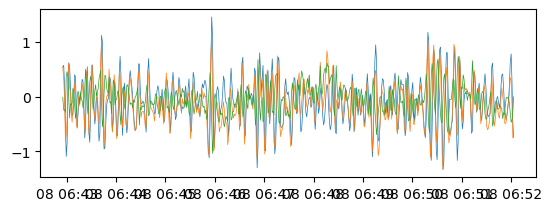

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x34a1e8f40>

In [64]:
subplot(2,1,1)
plot(stare1dt, heave, linewidth=0.5)
plot(stare1dt, mdv, linewidth=0.5)
plot(stare1dt, mdv - heave, linewidth=0.5) # subtract heave because its downward
# Heave beats with the mean doppler velocity.
# Suspect one or more clocks is bad.

In [56]:
Ur = zeros(size(dopplervel))
Vr = zeros(size(dopplervel))
ind = findindices( Dates.value.(stare1dt), Dates.value.(UV["time"]))
for ih in 1:ntop # loop to broadcast to consistent size
    # Ur[:,ih] .= indavg( UV[:ur][:,ih], ind )
    # Vr[:,ih] .= indavg( UV[:vr][:,ih], ind )
    Ur[:,ih] .= UV[:ur][ind,ih]
    Vr[:,ih] .= UV[:vr][ind,ih]
end

In [57]:
# questionable: fill all the mean relative velocities
isf = isfinite.(Vr)
Vr[.!isf] .= mean(Vr[isf])
Ur[.!isf] .= mean(Ur[isf])

37968-element view(::Vector{Float64}, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  42951, 42952, 42953, 42954, 42955, 42956, 42957, 42958, 42959, 42960]) with eltype Float64:
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
  ⋮
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925
 -1.8953817387421925

In [58]:
#=
plot(stare1dt, pitch)
plot(stare1dt, roll )
plot(stare1dt, heave)
xlim(stare1dt[[1, 60]])
=#

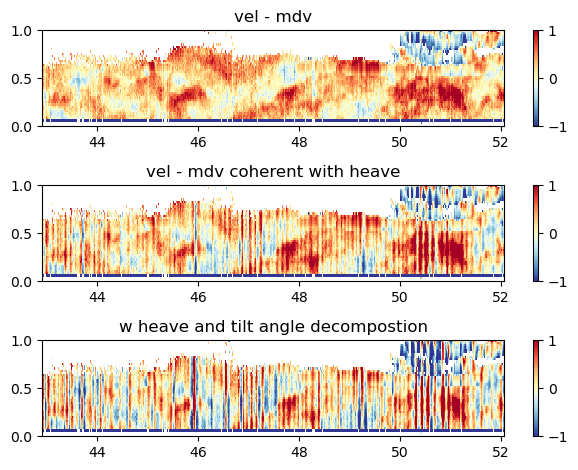

In [63]:
mm = @. minute(stare1dt) + (second(stare1dt) + millisecond(stare1dt)/1000 )/60

clf()
subplot(3,1,1)
pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
colorbar()
title("vel - mdv")
ylim([0, 1])

subplot(3,1,2)
pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv_remove)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
colorbar()
title("vel - mdv coherent with heave")
ylim([0, 1])

subplot(3,1,3)
w = wtrue.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
w = wtrue.(dopplervel, Ur, Vr, pitch*pi/180, roll*pi/180)
pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
colorbar()
title("w heave and tilt angle decompostion")
ylim([0, 1])

tight_layout()
# Corrections in wtrue (other than adding the -heave) do not seem to be important
# at this time. Motion compensation is probably working, then.

savefig("dopplervel_eg.png")

## prepare the structure function analysis

In [17]:
# stucture function constants
C2ll = 2.0
epsilon(A) = sqrt(3/4 * A/C2ll)^3
# struf(epsilon, r,r1) = C2ll * epsilon^(2/3) * r^(2/3) * (4 - (r1/r)^2)/3
# instruf(w1,w2) = (w1-w2)^2
# rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
# zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)


epsilon (generic function with 1 method)

In [18]:
(nt, nz) = size(w)
z1 = 7
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, z1) # might do outside the loop
zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                  pitch*pi/180,roll*pi/180, w; timestep=timestep )
rho = rhopair.(dr2, dz2) # approx r^2/3

143916-element Vector{Float64}:
  1.599908037349494
  3.0165769212718994
  5.031478140535772
  7.243683961507201
  9.098348970375998
 10.444703716946359
 11.487100485252833
 12.309253266647394
 13.161369698895214
 14.146742556103671
 15.3275893967964
 16.567535693381714
 17.520013408625477
  ⋮
  6.279654832794613
  8.099960624830873
  1.9416109517227247
  3.5323596597845857
  5.231318617571941
  7.189944601809093
  2.504959899176374
  4.438793626379982
  6.532637476439204
  3.0861375553337944
  5.464919306283902
  3.781648652290944

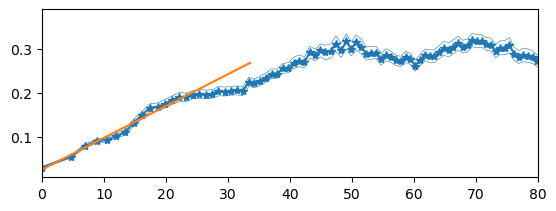

0.00014117111944731746

In [25]:
# devise equally-populated bins
nrho = length(rho)
nbin = 200
sp = sortperm(rho)
srho = rho[sp]
nin = round(Int32,nrho/nbin)
rhobin = [ 0; rho[sp[nin:nin:nrho]] ]
# maximum(rho), sort(rho)[length(rho)]
# plot(rhopair.(dr2, dz2), zm, marker=".", linestyle="none")
# hist(rhopair.(dr2, dz2), bins=20)

D2bin = binavg(D2, rho, rhobin)
D2var = binavg(D2.*D2, rho, rhobin) - D2bin.^2

# plot(rho, D2, marker=".", linestyle="none", markersize=.5)
out = 17
A = anom(rhobin[1:out]) \ anom(D2bin[1:out])
noise = mean(D2bin[1:out]) - A*mean(rhobin[1:out]) # noise
clf()
subplot(2,1,1)
plot(rhobin, D2bin, marker="*")
plot(rhobin, D2bin.+sqrt.(D2var/nin), color="tab:blue", linewidth=0.4)
plot(rhobin, D2bin.-sqrt.(D2var/nin), color="tab:blue", linewidth=0.4)
plot([0, 2.2*mean(rhobin[1:17])], noise .+ A.*[0, 2.2*mean(rhobin[1:17])])
xlim([0, 80])

epsilon(A) # 1.3e-4

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///Users/deszoeks/Projects/ASTRAL/lidar/In[328]#3:28\[90mIn[328]:3:28[0;0m]8;;\
C2ll = 2.0
struf(epsilon, r,r1) = C2ll[48;2;120;70;70m epsilon^(2/3) r^(2/3) (4 - (r1/r)^2)/3[0;0m
[90m#                          └─────────────────────────────────────┘ ── [0;0m[91mextra tokens after end of expression[0;0m

In [308]:
r_apx = @. sqrt(rhobins)^3 

200-element Vector{Float64}:
    0.0
    8.98305931350235
   16.27231623182235
   23.290293956758603
   29.994501761826214
   36.69219425927952
   43.82418166051697
   50.67284229351108
   57.54209178040157
   64.62509044089973
   71.58262926700347
   78.44277756874264
   85.46629912103026
    ⋮
 2062.8410707388084
 2091.758579919492
 2121.379089586547
 2152.9665963041207
 2186.0712662228257
 2221.474356888128
 2260.2049387239076
 2301.4438250732037
 2347.852404939588
 2399.939219933142
 2463.076473087157
 2545.7308052160524